In [1]:
#change utility1 by the corresponding number, get back utility 3  done
#change prompt done
#change pickle filename  done
#change plot name   done
#change objective name

In [2]:
import os
import warnings
from itertools import combinations

import numpy as np
import torch
import time

# Suppress potential optimization warnings for cleaner notebook
warnings.filterwarnings("ignore")

SMOKE_TEST = os.environ.get("SMOKE_TEST")

In [3]:
import DTLZ2_model
import fischer_model
from botorch.test_functions.multi_objective import DTLZ2
from DTLZ2_model import neg_l1_dist
from DTLZ2_model import predict_DTLZ2_model
from fischer_model import predict_fischer_model
import tensorflow as tf
import random


from botorch.fit import fit_gpytorch_mll 
from botorch.models.pairwise_gp import PairwiseGP, PairwiseLaplaceMarginalLogLikelihood 
from botorch.models.transforms.input import Normalize
import pickle

In [4]:
 #Your chosen seed
your_seed = 42

# Set seed for Python's RNG
random.seed(your_seed)

# Set seed for NumPy RNG
np.random.seed(your_seed)

# Set seed for PyTorch RNGs
torch.manual_seed(your_seed)

# Ensure reproducibility for PyTorch operations (might reduce performance)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# If using CUDA (PyTorch)
torch.cuda.manual_seed(your_seed)
torch.cuda.manual_seed_all(your_seed)  # For multi-GPU setups


In [5]:
predict_fischer_model(torch.tensor([[0.5, 0.5, 0.5, 0.5]]))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


tensor([[0.6455, 0.0591, 0.1161, 0.5071]])

In [6]:
import cohere
co = cohere.Client('9ylnov4iFULBLovujZIJLq6x8pkq4NkyNCw0oePR')

In [7]:
# data generating helper functions
#function that defines the comparisons
def utility(X):
    y=predict_fischer_model(X)
    #weighted_y = y * torch.sqrt(torch.arange(y.size(-1), dtype=torch.float) + 1)
    #y = torch.sum(weighted_y, dim=-1)
    return y

def utility1(X): #The four outputs are equally important, and we want to maximize all of them.
    y=predict_fischer_model(X)
    y = torch.sum(y, dim=-1)
    return y

def utility2(X): #We only want to maximize the CO conversion.
    y=predict_fischer_model(X)
    y = y[:,0]
    return y

def utility3(X): # The light olefins is considered as a negative output and we want to minimize it while maximizing the other three objectives.
    y=predict_fischer_model(X)
    y = y[:,0]+y[:,1]+y[:,2]-y[:,3]
    return y
    
def ini(n,dim):
    X = torch.rand(n, dim, dtype=torch.float64)
    return X
def generate_data(X, dim=4):
    """Generate data X and y"""
    # X is randomly sampled from dim-dimentional unit cube
    # we recommend using double as opposed to float tensor here for
    # better numerical stability
    #X=ini(n,dim)
    x_2=tf.convert_to_tensor(X, dtype=tf.float32)
    y = utility(x_2)
    return y

def generate_data_u1(X, dim=4):
    """Generate data X and y"""
    # X is randomly sampled from dim-dimentional unit cube
    # we recommend using double as opposed to float tensor here for
    # better numerical stability
    #X=ini(n,dim)
    x_2=tf.convert_to_tensor(X, dtype=tf.float32)
    y = utility1(x_2)
    return y

In [8]:
def generate_comparisons(y, n_comp, noise=0.1, replace=False):
    """Create pairwise comparisons with noise"""
    # generate all possible pairs of elements in y
    all_pairs = np.array(list(combinations(range(y.shape[0]), 2)))
    # randomly select n_comp pairs from all_pairs
    comp_pairs = all_pairs[
        np.random.choice(range(len(all_pairs)), n_comp, replace=replace)
    ]
    # add gaussian noise to the latent y values
    c0 = y[comp_pairs[:, 0]] + np.random.standard_normal(len(comp_pairs)) * noise
    c1 = y[comp_pairs[:, 1]] + np.random.standard_normal(len(comp_pairs)) * noise
    reverse_comp = (c0 < c1).numpy()
    comp_pairs[reverse_comp, :] = np.flip(comp_pairs[reverse_comp, :], 1)
    comp_pairs = torch.tensor(comp_pairs).long()

    return comp_pairs

In [9]:
#im not sure if this is is the correct function, i'm a bit eepy
#remember to reduce the number of comparisons n_comp,
def generate_comparisons_llm(y, n_comp, replace=False):
    """Create pairwise comparisons with noise"""
    # generate all possible pairs of elements in y
    all_pairs = np.array(list(combinations(range(y.shape[0]), 2)))
    # randomly select n_comp pairs from all_pairs
    comp_pairs = all_pairs[
        np.random.choice(range(len(all_pairs)), n_comp, replace=replace)
    ]
    #parsing the tensor to get the strings for the LLM
    new_pairs=[]
    for opto in comp_pairs:
        firstoption=opto[0]
        secondoption=opto[1]
        numfirst=(y[firstoption,:])
        firstoutput1=f"{numfirst[0].cpu().numpy():.1f}"
        firstoutput2=f"{numfirst[1].cpu().numpy():.1f}"
        firstoutput3=f"{numfirst[2].cpu().numpy():.1f}"
        firstoutput4=f"{numfirst[3].cpu().numpy():.1f}"
        numsecond=(y[secondoption,:])
        secondoutput1=f"{numsecond[0].cpu().numpy():.1f}"
        secondoutput2=f"{numsecond[1].cpu().numpy():.1f}"
        secondoutput3=f"{numsecond[2].cpu().numpy():.1f}"
        secondoutput4=f"{numsecond[3].cpu().numpy():.1f}"
        mess="Suppose you're managing a Fischer-Tropsch synthesis process. The four outputs are equally important, and we want to maximize all of them. Option A: regime of "+firstoutput1+" CO conversion, "+firstoutput2+" methane production, "+firstoutput3+" paraffins, "+firstoutput4+" light olefins. Option B: regime of "+secondoutput1+" CO conversion, "+secondoutput2+" methane production, "+secondoutput3+" paraffins, "+secondoutput4+" light olefins. Choose only one option, only answer with 'Option A' or 'Option B'"
        print(mess)
        response = co.chat(message=mess,
        #perform web search before answering the question. You can also use your own custom connector.
                          #connectors=[{"id": "web-search"}]
        )
        print(response.text)
        opllm=response.text
        
        if "Option A" in opllm:
            new_pairs.append(opto.tolist())
        else:
            new_pairs.append(list(reversed(opto)))
        #api restrictions 20 API calls/minutes
        time.sleep(6)
    
    return torch.tensor(new_pairs)

#"Suppose you're managing a Fischer-Tropsch synthesis process. The four outputs are equally important, and we want to maximize all of them. Option A: regime of "+firstoutput1+" CO conversion, "+firstoutput2+" methane production, "+firstoutput3+" paraffins, "+firstoutput4+" light olefins. Option B: regime of "+secondoutput1+" CO conversion, "+secondoutput2+" methane production, "+secondoutput3+" paraffins, "+secondoutput4+" light olefins. Choose only one option, only answer with 'Option A' or 'Option B'"
#"Suppose you're managing a Fischer-Tropsch synthesis process. The light olefins are considered as a negative output and we want to minimize them, while maximizing the other three outputs. Option A: regime of "+firstoutput1+" CO conversion, "+firstoutput2+" methane, "+firstoutput3+" paraffin, "+firstoutput4+" light olefins. Option B: regime of "+secondoutput1+" CO conversion, "+secondoutput2+" methane, "+secondoutput3+" paraffins, "+secondoutput4+" light olefins. Choose only one option, only answer with 'Option A' or 'Option B'"
#"Suppose you're managing a Fischer-Tropsch synthesis process. We only want to maximize the CO conversion. Option A: regime of "+firstoutput1+" CO conversion, "+firstoutput2+" methane, "+firstoutput3+" paraffin, "+firstoutput4+" light olefins. Option B: regime of "+secondoutput1+" CO conversion, "+secondoutput2+" methane, "+secondoutput3+" paraffins, "+secondoutput4+" light olefins. Choose only one option, only answer with 'Option A' or 'Option B'"

#parameters
torch.manual_seed(123)
#number for initial data
n = 5 if not SMOKE_TEST else 5
#number for initial comparisons
m = 10 if not SMOKE_TEST else 10
dim = 4
noise = 0.1

#generate data, initial data
train_X, train_y = generate_data(n, dim=dim)
#generating comparison based on the utility function

train_comp_llm = generate_comparisons_llm(train_y, m)

train_comp_llm

from botorch.fit import fit_gpytorch_mll
from botorch.models.pairwise_gp import PairwiseGP, PairwiseLaplaceMarginalLogLikelihood
from botorch.models.transforms.input import Normalize

#fitting the first pairwise GP
model = PairwiseGP(
    train_X,
    train_comp_llm,
    input_transform=Normalize(d=train_X.shape[-1]),
)
mll = PairwiseLaplaceMarginalLogLikelihood(model.likelihood, model)
mll = fit_gpytorch_mll(mll)

from scipy.stats import kendalltau


# Kendall-Tau rank correlation
def eval_kt_cor(model, test_X, test_y):
    pred_y = model.posterior(test_X).mean.squeeze().detach().numpy()
    return kendalltau(pred_y, test_y).correlation


n_kendall = 10 if not SMOKE_TEST else 10

test_X, test_y = generate_data(n_kendall, dim=dim)
kt_correlation = eval_kt_cor(model, test_X, test_y[:,3])

print(f"Test Kendall-Tau rank correlation: {kt_correlation:.4f}")

In [10]:
from botorch.acquisition.preference import AnalyticExpectedUtilityOfBestOption
from botorch.optim import optimize_acqf

#wrapper for the model
def init_and_fit_model(X, comp):
    """Model fitting helper function"""
    model = PairwiseGP(
        X,
        comp,
        input_transform=Normalize(d=X.shape[-1]),
    )
    mll = PairwiseLaplaceMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_mll(mll)
    return mll, model

#wrapper for making new data, what does it mean? return comps

def make_new_data(X, next_X, comps, q_comp):
    """Given X and next_X,
    generate q_comp new comparisons between next_X
    and return the concatenated X and comparisons
    """
    # next_X is float by default; cast it to the dtype of X (i.e., double)
    next_X = next_X.to(X)
    x_2=tf.convert_to_tensor(next_X, dtype=tf.float32)
    next_y = utility(x_2)
    next_comps = generate_comparisons_llm(next_y, n_comp=q_comp)
    comps = torch.cat([comps, next_comps + X.shape[-2]])
    X = torch.cat([X, next_X])
    return X, comps

def make_new_data_u1(X, next_X, comps, q_comp):
    """Given X and next_X,
    generate q_comp new comparisons between next_X
    and return the concatenated X and comparisons
    """
    # next_X is float by default; cast it to the dtype of X (i.e., double)
    next_X = next_X.to(X)
    x_2=tf.convert_to_tensor(next_X, dtype=tf.float32)
    next_y = utility1(x_2)
    next_comps = generate_comparisons(next_y, n_comp=q_comp)
    comps = torch.cat([comps, next_comps + X.shape[-2]])
    X = torch.cat([X, next_X])
    return X, comps

In [11]:
#two algorithms to compare
algos = ["EUBO","EUBO-LLM", "rand"]
#number of repetitions of the BO cycle
NUM_TRIALS = 3 if not SMOKE_TEST else 2
#number of cycles
NUM_BATCHES = 20 if not SMOKE_TEST else 2

#dimension number= 4 inputs
dim = 4
#sampler options
NUM_RESTARTS = 3
RAW_SAMPLES = 512 if not SMOKE_TEST else 8
#
q_eubo = 2  # number of points per query
q_data=5
q_comp = 10  # number of comparisons per query
q_comp_2=1

# initial evals
best_vals = {}  # best observed values
for algo in algos:
    best_vals[algo] = []

# average over multiple trials
for i in range(NUM_TRIALS):
    torch.manual_seed(i)
    np.random.seed(i)
    data = {}
    models = {}

     # X are within the unit cube
    bounds = torch.stack([torch.zeros(dim), torch.ones(dim)])

    # Create initial data
    init_X=ini(q_data,dim)
    for algo in algos:
        if algo == "EUBO-LLM":
            init_y = generate_data(init_X, dim=dim)
            comparisons = generate_comparisons_llm(init_y, q_comp)
        if algo == "EUBO":
            init_y = generate_data_u1(init_X, dim=dim)
            comparisons = generate_comparisons(init_y, q_comp)
        if algo == "rand":
            init_y = generate_data_u1(init_X, dim=dim)
            comparisons = generate_comparisons(init_y, q_comp)
   
        best_vals[algo].append([])
        data[algo] = (init_X, comparisons)
        _, models[algo] = init_and_fit_model(init_X, comparisons)

        best_next_y = utility1(init_X).max().item()
        best_vals[algo][-1].append(best_next_y)

    # we make additional NUM_BATCHES comparison queries after the initial observation
    for j in range(1, NUM_BATCHES + 1):
        print(j)
        for algo in algos:
            model = models[algo]
            if algo == "EUBO-LLM":
                # create the acquisition function object
                acq_func = AnalyticExpectedUtilityOfBestOption(pref_model=model)
                # optimize and get new observation
                next_X, acq_val = optimize_acqf(
                    acq_function=acq_func,
                    bounds=bounds,
                    q=q_eubo,
                    num_restarts=NUM_RESTARTS,
                    raw_samples=RAW_SAMPLES,
                )
                print(next_X)
                # update data
                X, comps = data[algo]
                X, comps = make_new_data(X, next_X, comps, q_comp_2)
                data[algo] = (X, comps)
    
                # refit models
                _, models[algo] = init_and_fit_model(X, comps)
    
                # record the best observed values so far
                max_val = utility1(X).max().item()
                best_vals[algo][-1].append(max_val)
            elif algo == "EUBO":
                 #create the acquisition function object
                acq_func = AnalyticExpectedUtilityOfBestOption(pref_model=model)
                # optimize and get new observation
                next_X, acq_val = optimize_acqf(
                    acq_function=acq_func,
                    bounds=bounds,
                    q=q_eubo,
                    num_restarts=NUM_RESTARTS,
                    raw_samples=RAW_SAMPLES,
                )
                print(next_X)
                # update data
                X, comps = data[algo]
                X, comps = make_new_data_u1(X, next_X, comps, q_comp_2)
                data[algo] = (X, comps)
    
                # refit models
                _, models[algo] = init_and_fit_model(X, comps)
    
                # record the best observed values so far
                max_val = utility1(X).max().item()
                best_vals[algo][-1].append(max_val)
            else:
                # randomly sample data
                next_X= ini(q_eubo, dim=dim)
                print(next_X)
                # update data
                X, comps = data[algo]
                X, comps = make_new_data_u1(X, next_X, comps, q_comp_2)
                data[algo] = (X, comps)
    
                # refit models
                _, models[algo] = init_and_fit_model(X, comps)
    
                # record the best observed values so far
                max_val = utility1(X).max().item()
                best_vals[algo][-1].append(max_val)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Suppose you're managing a Fischer-Tropsch synthesis process. The four outputs are equally important, and we want to maximize all of them. Option A: regime of 0.2 CO conversion, 0.0 methane production, 0.0 paraffins, 0.2 light olefins. Option B: regime of 0.6 CO conversion, 0.0 methane production, 0.1 paraffins, 0.5 light olefins. Choose only one option, only answer with 'Option A' or 'Option B'
Option B.
Suppose you're managing a Fischer-Tropsch synthesis process. The four outputs are equally important, and we want to maximize all of them. Option A: regime of 0.7 CO conversion, 0.1 methane production, 0.2 paraffins, 0.4 light olefins. Option B: regime of 0.2 CO conversion, 0.0 methane production, 0.0 paraffins, 0.2 light olefins. Choose only one option, only answer with 'Option A' or 'Option B'
Option A.
Suppose you're managing a Fischer-Tropsch synthesis process. The four o

In [12]:
with open('best_vals_case_1.pkl', 'wb') as handle:
    pickle.dump(best_vals, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
with open('best_vals_case_1.pkl', 'rb') as handle:
    loaded_data = pickle.load(handle)

In [14]:
loaded_data

{'EUBO': [[1.7897961139678955,
   1.8817813396453857,
   2.389305591583252,
   2.4298152923583984,
   2.873431444168091,
   3.1006925106048584,
   3.168034076690674,
   3.1998252868652344,
   3.23506760597229,
   3.23506760597229,
   3.23506760597229,
   3.23506760597229,
   3.23506760597229,
   3.23506760597229,
   3.23506760597229,
   3.23506760597229,
   3.23506760597229,
   3.23506760597229,
   3.23506760597229,
   3.23506760597229,
   3.23506760597229],
  [1.4082660675048828,
   1.6492469310760498,
   1.7769269943237305,
   1.921905755996704,
   2.2779784202575684,
   2.4001805782318115,
   2.501664638519287,
   2.501664638519287,
   2.5112767219543457,
   2.7181010246276855,
   2.7775518894195557,
   2.9565978050231934,
   2.979424476623535,
   2.979424476623535,
   2.979424476623535,
   3.069471597671509,
   3.2348551750183105,
   3.23506760597229,
   3.23506760597229,
   3.23506760597229,
   3.23506760597229],
  [2.1619651317596436,
   2.3921618461608887,
   2.4839630126953125,

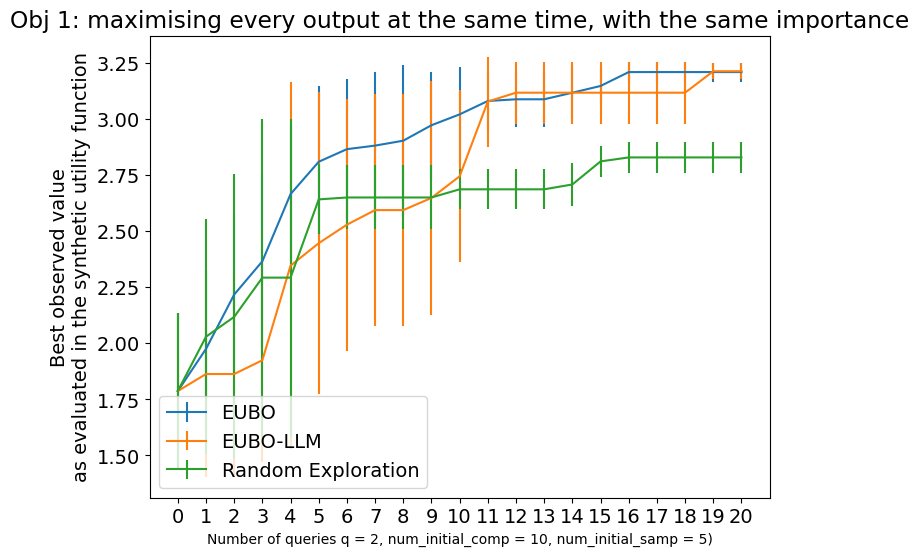

In [15]:
from matplotlib import pyplot as plt


%matplotlib inline

plt.rcParams.update({"font.size": 14})

algo_labels = {
    "rand": "Random Exploration",
    "EUBO-LLM": "EUBO-LLM",
    "EUBO": "EUBO", 
}


def ci(y):
    return 1.96 * y.std(axis=0) / np.sqrt(y.shape[0])


# the utility function is maximized at the full vector of 1
#optimal_val = utility(torch.tensor([[1] * dim])).item()
iters = list(range(NUM_BATCHES + 1))

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
# plot the optimal value
#ax.plot(
#    iters,
#    [optimal_val] * len(iters),
#    label="Optimal Function Value",
#    color="black",
##    linewidth=1.5,
#)

# plot the the best observed value from each algorithm
for algo in algos:
    ys = np.vstack(best_vals[algo])
    ax.errorbar(
        iters, ys.mean(axis=0), yerr=ci(ys), label=algo_labels[algo], linewidth=1.5
    )

ax.set(
    #xlabel=f"Number of queries q = {q_eubo}, num_initial_comp = {q_comp}, num_initial_samp = {q_data})",
    ylabel="Best observed value\nas evaluated in the synthetic utility function",
    title=f"Obj 1: maximising every output at the same time, with the same importance",
)

ax.set_xticks(np.arange(0, NUM_BATCHES + 1, 1))

ax.set_xlabel(f"Number of queries q = {q_eubo}, num_initial_comp = {q_comp}, num_initial_samp = {q_data})", fontsize=10)  # Reducing the font size
ax.legend(loc="best")
plt.savefig("comparison_first_case_1_corrected.png",bbox_inches="tight", dpi=400)